In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn#==0.23.1
import scipy#==1.4.1
import pandas as pd
from sklearn.decomposition import PCA
import pickle as pkl
from numpy.matlib import repmat
from bayes_opt import BayesianOptimization
import cma
from cma import CMAEvolutionStrategy
import random

main_folder = os.getcwd()
print(main_folder)
save_dir = main_folder+"\\opt_results\\"

gp_dir = main_folder + '\\save_GP\\'
datasets = os.listdir(main_folder)

# re-loading GP kernels previously fit
m_l = []
data_folder = main_folder + '\\save_GP\\_data\\'
subj_inds = np.load(data_folder + 'subj_inds.npy')
param_std = np.load(data_folder + 'param_std.npy')
param_mean = np.load(data_folder + 'param_mean.npy')
norm_params = np.load(data_folder + 'norm_params.npy')
norm_met = np.load(data_folder + 'norm_met.npy')
met_std = np.load(data_folder + 'met_std.npy')
met_mean = np.load(data_folder + 'met_mean.npy')

num_subjects = 5
gp_fold = main_folder + '\\save_GP\\' + '1_2 + WhiteKernel(noise_level=1) + Matern(length_scale=1, nu=0.5)\\'
for i in range(num_subjects):
    gp_l = pkl.load(open(gp_fold+'m'+str(i)+'.dump','rb'))
    m_l.append(gp_l)

C:\Users\patty\Simulating-Human-in-the-Loop-Optimization


In [2]:
#@title Function definitions
def optimize(method, dims, m_l, num_runs, converge_crit, meas_noise, param_range, x_mean, x_std, hyper_params, save_dir, save_name, param_bounds, seed=1, saving = False):
    # setting up GP process list
    if dims == 4:
        if time_varying:
            m_r_l = [[m_l[0],m_l[1]], [m_l[2],m_l[3]], [m_l[4],m_l[1]]]
        else:
            m_r_l = m_l
    elif dims == 8:
        m_r_l = [[m_l[0],m_l[1]], [m_l[2],m_l[3]]]
    elif dims == 12:
        m_r_l = [[m_l[0],m_l[1],m_l[2]], [m_l[2],m_l[3],m_l[4]]]
    elif dims == 16:
        m_r_l = [[m_l[0],m_l[1],m_l[2],m_l[3]]]
    elif dims == 20:
        m_r_l = [[m_l[0],m_l[1],m_l[2],m_l[3],m_l[4]]]

    # running optimizations for each
    save_list = []
    global cnt
    for i,gp in enumerate(m_r_l):
        print("Model",i)
        for j in range(num_runs):
            print(j)
            cnt = 0
            random.seed(seed)
            opt_inputs = [gp, converge_crit, meas_noise, param_range, x_mean, x_std, hyper_params, param_bounds]
            if method == 'ce':
                save_params = cross_entropy(opt_inputs)
            elif method == 'cma':
                save_params = cma(opt_inputs)
            elif method == 'bayes':
                save_params = bayes(opt_inputs)
            elif method == 'hyb':
                save_params = hybrid(opt_inputs)
            elif method == 'tbay':
                save_params = tuned_bayes(opt_inputs)
            else:
                print("Incorrect method assigned")
            save_list.append(save_params)
    if saving:
        np.save(save_dir+save_name+'.npy', save_list)
    return save_list, len(m_r_l)

def f(gp, x_eval, meas_noise=0., x_mean=0., x_std=1., std_scalar=5.3, min_dim = 4):
    # Returns function evaluation for a given GP model
    # Assumes normalized data and x_eval has shape [opt_dims,]
    if len(x_eval.shape) == 1:
        x_eval = np.expand_dims(x_eval,axis=-1)
    try:
        if time_varying:
            global cnt
            mean1 = gp[0].predict((x_eval.transpose()-x_mean)/x_std, return_std = False) # mean
            mean2 = gp[1].predict((x_eval.transpose()-x_mean)/x_std, return_std = False)
            count_frac = cnt/cnt_thresh
            mean = mean1*np.maximum(1-count_frac,0) + mean2*np.minimum(count_frac,1.)
            cnt += 1
        else:
            mean = 0
            dim_cnt = 0
            for gp_l in gp: # each one of these is a gp
                mean_temp = gp_l.predict((x_eval[dim_cnt:dim_cnt+min_dim].transpose()-x_mean[dim_cnt:dim_cnt+min_dim])/x_std[dim_cnt:dim_cnt+min_dim], return_std = False)
                mean += mean_temp
                dim_cnt+=min_dim
    except:
        mean = gp.predict((x_eval.transpose()-x_mean)/x_std, return_std = False)

    return mean * (1.0 + random.gauss(0, meas_noise))#meas_noise*np.random.randn())

def constrain_params(sampled_param, param_bounds):
    param_min = param_bounds[:,0]
    param_max = param_bounds[:,1]
    constrain_sample = np.minimum(np.maximum(sampled_param, param_min), param_max)
    return constrain_sample

def hybrid(opt_inputs):
    mean_list = []
    global gp
    gp, converge_crit, meas_noise, param_range, x_mean, x_std, hyper_params, param_bounds = opt_inputs
    num_samples = hyper_params[4]
    num_hyb = hyper_params[5]
    N = param_bounds.shape[0]
    x = np.mean(param_bounds, axis=1)# init point randomly selected for mean
    init_pts = 0
    pbounds = {}
    probe_params = {} # sample same first point
    for i in range(N):
        key = 'p'+str(i)
        val = (param_bounds[i,0], param_bounds[i,1])
        pbounds[key] = val
        probe_params[key] = x[i]
    optimizer = BayesianOptimization(f=bayes_wrap, pbounds=pbounds, verbose=0)#, random_state=1)
    optimizer.probe(params=probe_params)
    optimizer.maximize(init_points=init_pts, n_iter=num_hyb-init_pts)

    elite_dict = optimizer.max['params']
    print(optimizer.max['target'])
    cma_init = np.zeros(N)
    for i in range(N):
        key = 'p'+str(i)
        cma_init[i] = elite_dict[key]

    # perform cma for rest of the steps
    hyper_params[7] = hyper_params[6] # set the cma sigma to hyb_sigma value
    hyper_params[8] = cma_init
    hyper_params[3] = int(np.ceil((num_samples - num_hyb)/(4+int(np.floor(3*np.log(N)))))) # changing the number of generations
    opt_inputs = [gp, converge_crit, meas_noise, param_range, x_mean, x_std, hyper_params, param_bounds]
    cma_save = cma(opt_inputs)

    save_params = [optimizer.max['target'], optimizer.res, cma_save]
    return save_params

def cma(opt_inputs):
    gp, converge_crit, meas_noise, param_range, x_mean, x_std, hyper_params, param_bounds = opt_inputs
    mean_list = []
    N = param_bounds.shape[0]
    cma_init = hyper_params[8] # cma_mean
    if np.sum(cma_init) == 0:
        x = np.mean(param_bounds, axis=1)# init point randomly selected for mean
    else:
        x = cma_initz
    sigma = hyper_params[7]#4.0 #np.mean((np.amax(param_range,axis=1) - np.amin(param_range,axis=1))/4)
    lam = 4+int(np.floor(3*np.log(N)))
    stopeval = lam*(hyper_params[3]) # samples * generations
    xmean = x
    λ = 4+int(3*np.log(N))
    mu = λ // 2
    weights = np.log(mu + 1 / 2) - np.log(np.asarray(range(1, mu + 1))).astype(np.float32)
    weights = weights / np.sum(weights)
    mueff = (np.sum(weights) ** 2) / np.sum(weights ** 2)

    cc = (4 + mueff / N) / (N + 4 + 2 * mueff / N)
    cs = (mueff + 2) / (N + mueff + 5)
    c1 = 2 / ((N + 1.3) ** 2 + mueff)
    cmu = min(1 - c1, 2 * (mueff - 2 + 1 / mueff) / ((N + 2) ** 2 + mueff))
    damps = 1 + 2 * max(0, ((mueff - 1) / (N + 1)) ** 0.5 - 1) + cs

    pc = np.zeros(N).astype(np.float32)
    ps = np.zeros(N).astype(np.float32)
    B = np.eye(N, N).astype(np.float32)
    D = np.ones(N).astype(np.float32)
    C = B * np.diag(D ** 2) * B.T
    invsqrtC = B * np.diag(D ** -1) * B.T
    eigeneval = 0
    chiN = N ** 0.5 * (1 - 1 / (4 * N) + 1 / (21 * N ** 2))

    local_cnt = 0
    while local_cnt < stopeval:
        arx = np.zeros((λ, N))
        arfitness = np.zeros(λ)
        for k in range(λ):
            if local_cnt == 0: # fist sample
                arx[k] = x
            else:
                arx[k] = constrain_params(xmean + sigma * B.dot(D * np.random.randn(N)), param_bounds)
            arfitness[k] = f(gp, arx[k], meas_noise, x_mean, x_std)
            local_cnt += 1

        arindex = np.argsort(arfitness)
        arfit_old = np.copy(arfitness)
        arfitness = arfitness[arindex]

        xold = xmean
        xmean = weights.dot(arx[arindex[0:mu]])

        ps = (1 - cs) * ps + np.sqrt(cs * (2 - cs) * mueff) * invsqrtC.dot((xmean - xold) / sigma)
        hsig = np.linalg.norm(ps) / np.sqrt(1 - (1 - cs) ** (2 * local_cnt / λ)) / chiN < 1.4 + 2 / (N + 1)
        pc = (1 - cc) * pc + hsig * np.sqrt(cc * (2 - cc) * mueff) * ((xmean - xold) / sigma)
        artmp = (1 / sigma) * (arx[arindex[0:mu]] - xold)
        C = (1 - c1 - cmu) * C + c1 * (pc.dot(pc.T) + (1 - hsig) * cc * (2 - cc) * C) + cmu * artmp.T.dot(
            np.diag(weights)).dot(artmp)
        sigma = sigma * np.exp((cs / damps) * (np.linalg.norm(ps) / chiN - 1))

        if local_cnt - eigeneval > λ / (c1 + cmu) / N / 10:
            eigeneval = local_cnt
            C = np.triu(C) + np.triu(C, 1).T
            D, B = np.linalg.eig(C)
            D = np.sqrt(D)
            invsqrtC = B.dot(np.diag(D ** -1).dot(B.T))
        mean_list.append((xmean, np.mean(arfitness[:mu]), sigma**2 * B * np.diag(D ** 2) * B.T, arfit_old))
    return mean_list

def cross_entropy(opt_inputs):
    mean_list = []
    gp, converge_crit, meas_noise, param_range, x_mean, x_std, hyper_params, param_bounds = opt_inputs
    m = hyper_params[0]
    elite = hyper_params[1]
    num_gens = hyper_params[2]
    x_init = np.mean(param_bounds, axis=1)
    x = x_init
    cov = 16.0*np.eye(len(x_init))#(np.amax(param_range,axis=1) - np.amin(param_range,axis=1))/2.*np.eye(len(x_mean))
    not_done = True
    f_best = np.inf
    f_gen = np.zeros(m)
    gen_cnt = 0
    while(gen_cnt < num_gens):
        samples = np.random.multivariate_normal(x, cov, size=m)
        if gen_cnt == 0:
            samples[0,:] = x_init
        samples = constrain_params(samples, param_bounds)
        for i in range(m):
            f_gen[i] = f(gp, samples[i], meas_noise, x_mean, x_std)
        args = np.argsort(f_gen) # sort points by funct val, keep elite best
        elite_samples = args[:elite]
        if f_gen[elite_samples[0]] < f_best: # update best
            f_best = f_gen[elite_samples[0]]
            x_best = samples[elite_samples[0],:]
        x = np.mean(samples[elite_samples,:],axis=0)
        cov = np.cov(samples[elite_samples,:],rowvar=False)
        gen_cnt += 1
        mean_list.append((x, np.mean(f_gen[args[:elite]]), cov, np.copy(f_gen)))
    return mean_list

def bayes_wrap(**kwargs):
    dim = len(kwargs)
    x_val = np.zeros(dim)
    for i,[key, value] in enumerate(kwargs.items()):
        x_val[i] = value
    f_val = -f(gp, x_val, meas_noise, x_mean, x_std)
    return f_val[0]

def bayes(opt_inputs):
    mean_list = []
    global gp
    gp, converge_crit, meas_noise, param_range, x_mean, x_std, hyper_params, param_bounds = opt_inputs
    m = hyper_params[0]
    num_samples = hyper_params[4]
    N = param_bounds.shape[0]
    x = np.mean(param_bounds, axis=1)# init point randomly selected for mean
    init_pts = 0 #4+int(np.floor(3*np.log(N)))
    pbounds = {}
    probe_params = {} # sample same first point
    for i in range(N):
        key = 'p'+str(i)
        val = (param_bounds[i,0], param_bounds[i,1])
        pbounds[key] = val
        probe_params[key] = x[i]
    optimizer = BayesianOptimization(f=bayes_wrap, pbounds=pbounds, verbose=0)#, random_state=1)
    optimizer.probe(params=probe_params)
    #print(num_samples)
    optimizer.maximize(init_points=init_pts, n_iter=num_samples-init_pts)
    #print(len(optimizer.res))
    save_params = [optimizer.max['target'], optimizer.res,]
    return save_params
    # can prob estimate the confidence interval by doing:
    # def posterior(optimizer, x_obs, y_obs, grid):
    #     optimizer._gp.fit(x_obs, y_obs)
    #     print(dir(optimizer))
    #     mu, sigma = optimizer._gp.predict(grid, return_std=True)
    #     return mu, sigma
    # x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    # y_obs = np.array([res["target"] for res in optimizer.res])
    # mu, sigma = posterior(optimizer, x_obs, y_obs, x) # x is either something like this: 'x': (2,4), or a range of values?

def tuned_bayes(opt_inputs):
    mean_list = []
    global gp
    gp, converge_crit, meas_noise, param_range, x_mean, x_std, hyper_params, param_bounds = opt_inputs
    m = hyper_params[0]
    num_samples = hyper_params[4]
    N = param_bounds.shape[0]
    x = np.mean(param_bounds, axis=1)# init point randomly selected for mean
    init_pts = 8 #4+int(np.floor(3*np.log(N)))
    pbounds = {}
    probe_params = {} # sample same first point
    for i in range(N):
        key = 'p'+str(i)
        val = (param_bounds[i,0], param_bounds[i,1])
        pbounds[key] = val
        probe_params[key] = x[i]
    optimizer = BayesianOptimization(f=bayes_wrap, pbounds=pbounds, verbose=0)#, random_state=1)
    optimizer.probe(params=probe_params)
    optimizer.maximize(init_points=init_pts, n_iter=num_samples-init_pts, acq="ucb", kappa_decay=0.93)
    save_params = [optimizer.max['target'], optimizer.res,]
    return save_params

if True: # hiding plotting details
    # TODO: have separate plotting function/file that takes in list of results files to load, and corresponding labels and colors for plotting
    plt.rcParams['font.family'] = "sans-serif"
    plt.rcParams['font.sans-serif'] = 'Helvetica'
    plt.rcParams['axes.edgecolor']='k'
    plt.rcParams['axes.linewidth']=1.2
    plt.rcParams['xtick.color']='k'
    plt.rcParams['ytick.color']='k'
    plt_txt = 8
    def_marker_size=7
    plt.rcParams.update({'font.size': plt_txt})
    # color scheme
    black = 'k'
    grey = '#b7b6b6' #'#c7c6c6' #8f8e8d'
    dark_grey = '#838281'#737271'#646362'#'#414141'
    purple = '#f69cf4'
    lblue = '#5ac5ff'
    blue = '#0091ea'
    purple_as = '#bf32e7'
    green = '#00c853'
    orange = '#ffab00'
    red = '#ff3d00'
    alpha = 0.2
    def update_prop(handle, orig):
        handle.update_from(orig)
        handle.set_marker("s")
        handle.set_markersize(def_marker_size)
    plt.rcParams['legend.handlelength'] = 0
    from matplotlib.legend_handler import HandlerLine2D
    import matplotlib.patches as mpatches
    from matplotlib.legend_handler import HandlerPatch
    class HandlerSquare(HandlerPatch):
        def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
            center = xdescent + 0.5 * (width - height), ydescent
            p = mpatches.Rectangle(xy=center, width=height, height=height, angle=0.0)
            self.update_prop(p, orig_handle, legend)
            p.set_transform(trans)
            return [p]

            # take the data pulled from the optimization and reformat it to plottable data

def process_sim(method, save_list, num_runs, num_landscapes, dim, hyper_params):
    # output: x_mean_path [num_landscape, num_run, generations, dim], use large number placeholder for generations, store movement of mean val
        # sample_cnt  [num_landscape, num_run]
        # x_cov_path  [num_landscape, num_run, generations] # storing l2 norm of eig values
        # f_val       [num_landscape, num_run, generations] # storing average cost of elite samples
    if method == 'ce':
        samples_per_gen = hyper_params[0]
        num_gens = hyper_params[2]
        tot_samples = samples_per_gen*num_gens
    elif method == 'cma':
        num_gens = hyper_params[3]
        samples_per_gen = 4+int(np.floor(3*np.log(dim)))
        tot_samples = samples_per_gen*num_gens
    elif method == 'bayes' or method == 'tbay':
        tot_samples = hyper_params[4]
        num_gens = 1
        samples_per_gen = 1
    elif method == 'hyb':
        tot_samples = hyper_params[4]
        hyb_samples = hyper_params[5]
        samples_per_gen = 4+int(np.floor(3*np.log(dim)))
        num_gens = (tot_samples - hyb_samples)//samples_per_gen
    x_mean_path = np.zeros((num_landscapes, num_runs, num_gens, dim))
    x_cov_path = np.zeros((num_landscapes, num_runs, num_gens))
    f_val = np.zeros((num_landscapes, num_runs, num_gens))
    f_eval = np.zeros((num_landscapes, num_runs, tot_samples))
    f_eval_min = np.zeros((num_landscapes, num_runs, tot_samples))
    sample_cnt = np.zeros((num_landscapes, num_runs))
    for i in range(num_landscapes):
        for j in range(num_runs):
            l_i = j + i*num_runs
            # save list has [runs*landscapes] [generations] [values from individual run]
            eval_cnt = 0
            if method == 'cma' or method == 'ce':
                for k in range(num_gens):#len(save_list[l_i])): # num generations
                    x_mean_path[i,j,k,:] = save_list[l_i][k][0] # storing movement of mean values
                    f_val[i,j,k] = save_list[l_i][k][1] # storing cost values
                    cov = save_list[l_i][k][2] # storing movement of mean values
                    x_cov_path[i,j,k] = np.linalg.norm(np.linalg.eig(cov)[0])
                    f_eval[i,j,eval_cnt:eval_cnt+samples_per_gen] = save_list[l_i][k][3]
                    eval_cnt += samples_per_gen
            elif method == 'bayes' or method == 'tbay':
                best, param_list = save_list[l_i]
                #if tot_samples != len(param_list)+1:
                #    print("Error in number of samples for one trial:", tot_samples, len(param_list))
                for k in range(tot_samples):
                    try:
                        sample = param_list[k]
                    except:
                        sample = param_list[-1]
                    f_eval[i,j,k] = -sample['target'] # can extract param w/ 'params'
            elif method == 'hyb':
                best, param_list, cma_list = save_list[l_i]
                for k in range(hyb_samples): # process bayes samples
                    try:
                        sample = param_list[k]
                    except:
                        sample = param_list[-1]
                    f_eval[i,j,k] = -sample['target'] # can extract param w/ 'params'
                eval_cnt = hyb_samples
                for k in range(num_gens):
                    f_eval[i,j,eval_cnt:eval_cnt+samples_per_gen] = cma_list[k][3]
                    eval_cnt += samples_per_gen
            for k in range(1,tot_samples): # re-arrange so always have minimum
                f_eval_min[i,j,k-1] = np.amin(f_eval[i,j,:k])
            ### check for convergence w/ sliding window here
    return x_mean_path, x_cov_path, f_val, sample_cnt, f_eval, f_eval_min

def plot_perf(x_mean_path, x_cov_path, f_val, sample_cnt):
    fig, ax = plt.subplots(2, figsize=(10,14))

    # plot change in cost as a function of the generations
    ax[0].plot(np.mean(f_val,axis=1).transpose())
    ax[0].set_ylabel("Function cost")
    ax[0].set_xlabel("Generation")

    # plot change in sigma vs function of generations
    ax[1].plot(np.mean(x_cov_path,axis=1).transpose())
    ax[1].set_ylabel("Covariance matrix eigenvalue L2")
    ax[1].set_xlabel("Generation")
    plt.show()

def plot_methods(methods, f_eval_list, f_eval_min_list, save_tag = "None", saving=False, m_c=[red,purple_as, blue, green]):
    fig, ax = plt.subplots(2, figsize=(3.4,7))
    for i, method in enumerate(methods):
        f_eval_min = f_eval_min_list[i] # [num subjs, num_runs, num_samples]
        f_eval_mean = np.mean(f_eval_min, axis=(0,1))[:min_total_samples-1]
        f_eval_std = np.mean(np.std(f_eval_min, axis=1),axis=0)[:min_total_samples-1]
        ax[0].plot(f_eval_mean, c=m_c[i], label=methods_labels[method])
        ax[0].fill_between(np.arange(len(f_eval_mean)),f_eval_mean + f_eval_std, f_eval_mean - f_eval_std, color=m_c[i], alpha = alpha)
        ax[0].set_title('Best sample so far')
        f_eval = np.mean(f_eval_list[i], axis=(0,1))[:min_total_samples]
        f_eval_spread = np.mean(np.std(f_eval_list[i], axis=1), axis=0)[:min_total_samples]
        f_eval_bottom = np.mean(np.amin(f_eval_list[i], axis=1), axis=0)[:min_total_samples]
        f_eval_top = np.mean(np.amax(f_eval_list[i], axis=1), axis=0)[:min_total_samples]
        #ax[1].fill_between(np.arange(len(f_eval)),f_eval + f_eval_spread, f_eval - f_eval_spread, color=m_c[i], alpha = alpha)
        ax[1].fill_between(np.arange(len(f_eval)),f_eval_bottom, f_eval_top, color=m_c[i], alpha = alpha)
        ax[1].set_title('Samples at each step')
        #ax[1].scatter(np.arange(len(f_eval)),f_eval, c=m_c[i])
    ax[0].set_ylabel("Metabolic cost")
    ax[0].set_xlabel("Samples")
    ax[0].spines['top'].set_color('none')
    ax[0].spines['right'].set_color('none')
    # plot funct value as samples (scatter)
    ax[1].set_ylabel("Metabolic cost")
    ax[1].set_xlabel("Samples")
    ax[1].spines['top'].set_color('none')
    ax[1].spines['right'].set_color('none')
    ax[0].legend(loc='upper right', frameon=False, handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
    plt.subplots_adjust(hspace=0.4)

    if saving:
        save_fold = main_folder + 'plots/'
        filename = 'feval_plot' + save_tag
        plt.savefig(save_fold+filename+".svg", bbox_inches = 'tight', dpi=1200, pad_inches = 0)
        # plt.savefig(save_dir+filename+".eps", bbox_inches = 'tight', dpi=1200, pad_inches = 0)
        plt.savefig(save_fold+filename+".png", bbox_inches = 'tight', dpi=1200, pad_inches = 0)
    plt.show()

In [ ]:
#@title Simulation function

saving = True
dims = 12
methods = ['bayes']#'tbay','cma','ce']#,'bayes'] #'tbay'# optimization algorithm
methods_labels = {'tbay':'Tuned Bayes','hyb':'Hybrid', 'ce':'Cross-Entropy', 'cma':'Covariance Matrix\nAdaptation (ES)', 'bayes':'Bayesian\nOptimization'}
meas_noise = 0.046 # measurement noise as a percent motivated by HILO paper
num_runs = 40#40 # number of random restarts for each method, for each GP model
num_gens_cma = 50#12 # 12 for short, 24 for long
num_gens_ce = int(np.maximum(1,num_gens_cma//2)) # error with size of CE when it gets larger than 2?
time_varying = False
cnt_thresh = 80. # number of samples to transition over
cnt = 0
hyb_init = 130
hyb_sigma = 0.3#0.3
sigma = 2.
if True: # hiding calculation of other parameters
    param_min = np.amin(norm_params,axis=0)
    param_max = np.amax(norm_params,axis=0)
    param_range = np.vstack((param_min,param_max)).transpose()
    param_bounds = np.zeros((4,2))
    param_bounds[0,:] = np.array([0,1.]) # max torque as % Nm/kg
    param_bounds[1,:] = np.array([35,55]) # limits on peak time bounds
    param_bounds[2,:] = np.array([10,40]) # rise/fall time bounds
    param_bounds[3,:] = np.array([5,20]) # rise/fall time bounds
    mult = dims//4
    norm_param_bounds = np.zeros((dims,2))
    for i in range(mult):
        norm_param_bounds[i*4:(i+1)*4,:] = (param_bounds - np.expand_dims(param_mean,axis=1))/np.expand_dims(param_std,axis=1)
    x_mean = np.zeros(dims)
    x_std = np.ones(dims)
    save_name = str(methods) + '_' + str(num_runs)
    converge_crit = 0.05# NOT USED RN
    cma_samples_per_gen = 4+int(np.floor(3*np.log(dims)))
    m = 2*cma_samples_per_gen
    elite = m//2
    min_total_samples = np.minimum(m*num_gens_ce, cma_samples_per_gen*num_gens_cma)
    cma_mean = np.zeros(dims)
    hyper_params = [m, elite, num_gens_ce, num_gens_cma, min_total_samples, hyb_init, hyb_sigma, sigma, cma_mean, param_bounds] # m, elite, num_gens (ce), num_gens (cma)
    seed = 1 # seed for rng

# calling main optimize function
f_eval_list = []
f_eval_min_list = []
for i,method in enumerate(methods):
    print(method)
    np.random.seed(seed)
    save_list, num_landscapes = optimize(method, dims, m_l, num_runs,converge_crit, meas_noise, param_range, x_mean, x_std, hyper_params, save_dir, save_name, norm_param_bounds, seed)
    x_mean_path, x_cov_path, f_val, sample_cnt, f_eval, f_eval_min = process_sim(method, save_list, num_runs, num_landscapes, dims, hyper_params)
    f_eval_list.append(f_eval)
    f_eval_min_list.append(f_eval_min)
    if saving:
        np.save(save_dir+method+"_feval_"+str(num_runs)+"_"+str(len(x_mean))+".npy",f_eval)
        np.save(save_dir+method+"_feval_min_"+str(num_runs)+"_"+str(len(x_mean))+".npy",f_eval_min)
        if method == 'cma':
            np.save(save_dir+method+"_mean_"+str(num_runs)+"_"+str(len(x_mean))+".npy",x_mean_path)
            np.save(save_dir+method+"_cov_"+str(num_runs)+"_"+str(len(x_mean))+".npy",x_cov_path)
    #plot_perf(x_mean_path, x_cov_path, f_val, sample_cnt) # visualizing more details
plot_methods(methods, f_eval_list, f_eval_min_list)

bayes
Model 0
0


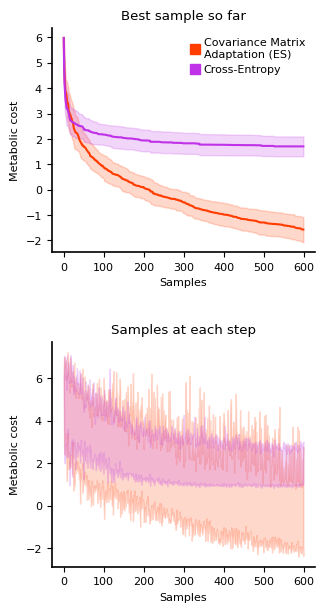

In [7]:
plot_methods(methods, f_eval_list, f_eval_min_list)

In [ ]:
#@title Simulation function

saving = True
dims = 12
methods = ['cma','ce','tbay','bayes']#'cma','ce']#,'bayes'] #'tbay'# optimization algorithm
methods_labels = {'tbay':'Tuned Bayes','hyb':'Hybrid', 'ce':'Cross-Entropy', 'cma':'Covariance Matrix\nAdaptation (ES)', 'bayes':'Bayesian\nOptimization'}
meas_noise = 0.046 # measurement noise as a percent motivated by HILO paper
num_runs = 40#40 # number of random restarts for each method, for each GP model
num_gens_cma = 50#12 # 12 for short, 24 for long
num_gens_ce = int(np.maximum(1,num_gens_cma//2)) # error with size of CE when it gets larger than 2?
time_varying = False
cnt_thresh = 80. # number of samples to transition over
cnt = 0
hyb_init = 130
hyb_sigma = 0.3#0.3
sigma = 2.
if True: # hiding calculation of other parameters
    param_min = np.amin(norm_params,axis=0)
    param_max = np.amax(norm_params,axis=0)
    param_range = np.vstack((param_min,param_max)).transpose()
    param_bounds = np.zeros((4,2))
    param_bounds[0,:] = np.array([0,1.]) # max torque as % Nm/kg
    param_bounds[1,:] = np.array([35,55]) # limits on peak time bounds
    param_bounds[2,:] = np.array([10,40]) # rise/fall time bounds
    param_bounds[3,:] = np.array([5,20]) # rise/fall time bounds
    mult = dims//4
    norm_param_bounds = np.zeros((dims,2))
    for i in range(mult):
        norm_param_bounds[i*4:(i+1)*4,:] = (param_bounds - np.expand_dims(param_mean,axis=1))/np.expand_dims(param_std,axis=1)
    x_mean = np.zeros(dims)
    x_std = np.ones(dims)
    save_name = str(methods) + '_' + str(num_runs)
    converge_crit = 0.05# NOT USED RN
    cma_samples_per_gen = 4+int(np.floor(3*np.log(dims)))
    m = 2*cma_samples_per_gen
    elite = m//2
    min_total_samples = np.minimum(m*num_gens_ce, cma_samples_per_gen*num_gens_cma)
    cma_mean = np.zeros(dims)
    hyper_params = [m, elite, num_gens_ce, num_gens_cma, min_total_samples, hyb_init, hyb_sigma, sigma, cma_mean, param_bounds] # m, elite, num_gens (ce), num_gens (cma)
    seed = 1 # seed for rng

# calling main optimize function
f_eval_list = []
f_eval_min_list = []
for i,method in enumerate(methods):
    print(method)
    np.random.seed(seed)
    save_list, num_landscapes = optimize(method, dims, m_l, num_runs,converge_crit, meas_noise, param_range, x_mean, x_std, hyper_params, save_dir, save_name, norm_param_bounds, seed)
    x_mean_path, x_cov_path, f_val, sample_cnt, f_eval, f_eval_min = process_sim(method, save_list, num_runs, num_landscapes, dims, hyper_params)
    f_eval_list.append(f_eval)
    f_eval_min_list.append(f_eval_min)
    if saving:
        np.save(save_dir+method+"_feval_"+str(num_runs)+"_"+str(len(x_mean))+".npy",f_eval)
        np.save(save_dir+method+"_feval_min_"+str(num_runs)+"_"+str(len(x_mean))+".npy",f_eval_min)
        if method == 'cma':
            np.save(save_dir+method+"_mean_"+str(num_runs)+"_"+str(len(x_mean))+".npy",x_mean_path)
            np.save(save_dir+method+"_cov_"+str(num_runs)+"_"+str(len(x_mean))+".npy",x_cov_path)
    #plot_perf(x_mean_path, x_cov_path, f_val, sample_cnt) # visualizing more details
plot_methods(methods, f_eval_list, f_eval_min_list)

cma
Model 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


C:\Users\patty\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\patty\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\patty\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\patty\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\patty\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\patty\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\patty\anaconda3\envs\py37\lib\site-packages\ipykernel_launche

34
35
36
37
38
39
Model 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
ce
Model 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Model 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
tbay
Model 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Model 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
bayes
Model 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Model 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


In [ ]:
methods = methods = ['hyb','bayes','cma','ce']
methods_labels = {'ce':'Cross-Entropy', 'cma':'Covariance Matrix\nAdaptation (ES)', 'bayes':'Bayesian\nOptimization'}
saving = True
dim = dims
num_runs = num_runs
f_eval_list = []
f_eval_min_list = []
for method in methods:
    f_eval = np.load(save_dir+method+"_feval_"+str(num_runs)+"_"+str(dim)+".npy")
    f_eval_min = np.load(save_dir+method+"_feval_min_"+str(num_runs)+"_"+str(dim)+".npy")
    f_eval_list.append(f_eval)
    f_eval_min_list.append(f_eval_min)
plot_methods(methods, f_eval_list, f_eval_min_list, "_"+str(num_runs)+"_"+str(dim), saving)

In [ ]:
# make overlaid plotting for the version with and without the moving cost function over time
def plot_dual_methods(methods, f_eval_list, f_eval_min_list, f_eval_list2, f_eval_min_list2, save_tag = "None", saving=False, m_c=[purple_as, blue, green]):
    fig, ax = plt.subplots(2, figsize=(3.4,7))
    for i, method in enumerate(methods):
        f_eval_min = f_eval_min_list[i] # [num subjs, num_runs, num_samples]
        f_eval_mean = np.mean(f_eval_min, axis=(0,1))[:min_total_samples-1]
        f_eval_std = np.mean(np.std(f_eval_min, axis=1),axis=0)[:min_total_samples-1]
        ax[0].plot(f_eval_mean, c=m_c[i], label=methods_labels[method])
        ax[0].fill_between(np.arange(len(f_eval_mean)),f_eval_mean + f_eval_std, f_eval_mean - f_eval_std, color=m_c[i], alpha = alpha)

        f_eval_mean2 = np.mean(f_eval_min2, axis=(0,1))[:min_total_samples-1]

        f_eval = np.mean(f_eval_list[i], axis=(0,1))[:min_total_samples]
        f_eval_spread = np.mean(np.std(f_eval_list[i], axis=1), axis=0)[:min_total_samples]
        f_eval_bottom = np.mean(np.amin(f_eval_list[i], axis=1), axis=0)[:min_total_samples]
        f_eval_top = np.mean(np.amax(f_eval_list[i], axis=1), axis=0)[:min_total_samples]
        ax[0].plot(f_eval_mean2, c=m_c[i], linestyle='--')
        #ax[0].fill_between(np.arange(len(f_eval_mean)),f_eval_mean2 + f_eval_std2, f_eval_mean2 - f_eval_std2, color=m_c[i], alpha = alpha)

        #ax[1].fill_between(np.arange(len(f_eval)),f_eval + f_eval_spread, f_eval - f_eval_spread, color=m_c[i], alpha = alpha)
        ax[1].fill_between(np.arange(len(f_eval)),f_eval_bottom, f_eval_top, color=m_c[i], alpha = alpha)
        ax[1].set_title('Samples at each step')
        #ax[1].scatter(np.arange(len(f_eval)),f_eval, c=m_c[i])
    ax[0].set_title('Best sample so far')
    ax[0].set_ylabel("Metabolic cost")
    ax[0].set_xlabel("Samples")
    ax[0].spines['top'].set_color('none')
    ax[0].spines['right'].set_color('none')
    # plot funct value as samples (scatter)
    # ax[1].set_ylabel("Function cost")
    # ax[1].set_xlabel("Samples")
    # ax[1].spines['top'].set_color('none')
    # ax[1].spines['right'].set_color('none')
    ax[0].legend(loc='upper right', frameon=False, handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
    plt.subplots_adjust(hspace=0.4)

    if saving:
        save_fold = main_folder + 'plots/'
        filename = 'feval_plot' + save_tag
        plt.savefig(save_fold+filename+".svg", bbox_inches = 'tight', dpi=1200, pad_inches = 0)
        # plt.savefig(save_dir+filename+".eps", bbox_inches = 'tight', dpi=1200, pad_inches = 0)
        plt.savefig(save_fold+filename+".png", bbox_inches = 'tight', dpi=1200, pad_inches = 0)
    plt.show()

methods = methods = ['bayes','cma','ce']
methods_labels = {'ce':'Cross-Entropy', 'cma':'Covariance Matrix\nAdaptation (ES)', 'bayes':'Bayesian\nOptimization'}
saving = True
dim = 4
num_runs = 10
num_runs2 = 19
f_eval_list = []
f_eval_min_list = []
for method in methods:
    f_eval = np.load(save_dir+method+"_feval_"+str(num_runs)+"_"+str(dim)+".npy")
    f_eval_min = np.load(save_dir+method+"_feval_min_"+str(num_runs)+"_"+str(dim)+".npy")
    f_eval_list.append(f_eval)
    f_eval_min_list.append(f_eval_min)

f_eval_list2 = []
f_eval_min_list2 = []
for method in methods:
    f_eval2 = np.load(save_dir+method+"_feval_"+str(num_runs2)+"_"+str(dim)+".npy")
    f_eval_min2 = np.load(save_dir+method+"_feval_min_"+str(num_runs2)+"_"+str(dim)+".npy")
    f_eval_list2.append(f_eval2)
    f_eval_min_list2.append(f_eval_min2)

plot_dual_methods(methods, f_eval_list, f_eval_min_list, f_eval_list2, f_eval_min_list2, "_"+str(num_runs)+"_"+str(dim)+'_comb', saving)

In [ ]:
# make script to plot the performance across a range of dimensions

In [ ]:
# scrap code testing other cma version
gp = m_l[0]
N = len(x_mean)
sigma = 1.0 # mult by something?
es = CMAEvolutionStrategy(N*[0], sigma)
iter_lim = 6
i = 0
while i <= iter_lim: #iter_limnot es.stop():
    solutions = es.ask()
    es.tell(solutions, [f(gp, x, meas_noise, x_mean, x_std) for x in solutions])
    es.logger.add()
    es.disp()
    i += 1
es.result_pretty()
es.logger.plot()